## 1. Imports packages

In [15]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from scipy.stats import skew
from scipy.stats import f_oneway


# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

from library.sb_utils import save_file
print("Loaded Libraries")

Loaded Libraries


In [2]:
sns.set()

## 2. Load Data

We will use the cleaned data in EDA step

In [3]:
df_cleaned = pd.read_csv('../data/house_price_cleaned_data.csv')
df_cleaned.shape


print('The data have ', df_cleaned.shape[0], ' rows and ', df_cleaned.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(df_cleaned.columns)))

The data have  1459  rows and  59  columns

column names: 

MSSubClass
MSZoning
LotArea
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
ExterQual
ExterCond
Foundation
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
Functional
Fireplaces
GarageCars
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SaleType
SaleCondition
SalePrice


In [14]:
df_cleaned.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,SC60,RL,8450,Pave,4,Lvl,AllPub,Inside,3,CollgCr,...,0,0,0,0,0,Feb,2008,WD,Normal,12.248
1,SC20,RL,9600,Pave,4,Lvl,AllPub,FR2,3,Veenker,...,0,0,0,0,0,May,2007,WD,Normal,12.109
2,SC60,RL,11250,Pave,3,Lvl,AllPub,Inside,3,CollgCr,...,0,0,0,0,0,Sep,2008,WD,Normal,12.317
3,SC70,RL,9550,Pave,3,Lvl,AllPub,Corner,3,Crawfor,...,272,0,0,0,0,Feb,2006,WD,Abnorml,11.849
4,SC60,RL,14260,Pave,3,Lvl,AllPub,FR2,3,NoRidge,...,0,0,0,0,0,Dec,2008,WD,Normal,12.429


#### Looking for outliers


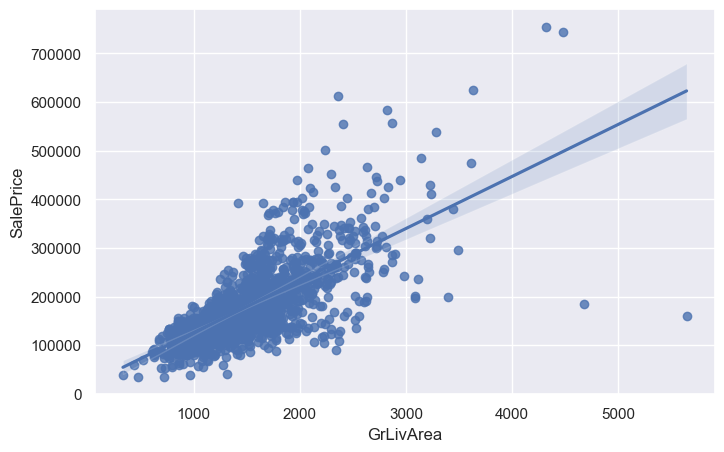

In [5]:
f, ax = plt.subplots(figsize=(8, 5))
sns.regplot(x=df_cleaned['GrLivArea'], y=df_cleaned['SalePrice'], data=df_cleaned)
plt.show()

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.

In [6]:
df_cleaned = df_cleaned[df_cleaned.GrLivArea < 4000]

In [7]:
# Log transform the target for official scoring
df_cleaned.SalePrice = np.log1p(df_cleaned.SalePrice)
y = df_cleaned.SalePrice

#### Some numerical features are actually really categories

In [8]:
df_cleaned = df_cleaned.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

#### Encode some categorical features as ordered numbers when there is information in the order

In [9]:
df_cleaned = df_cleaned.replace({"ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                                 "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                                 "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                 "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                 "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                                 "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                                 "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2}})
                                                 

In [10]:
df_cleaned.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,SC60,RL,8450,Pave,4,Lvl,AllPub,Inside,3,CollgCr,...,0,0,0,0,0,Feb,2008,WD,Normal,12.248
1,SC20,RL,9600,Pave,4,Lvl,AllPub,FR2,3,Veenker,...,0,0,0,0,0,May,2007,WD,Normal,12.109
2,SC60,RL,11250,Pave,3,Lvl,AllPub,Inside,3,CollgCr,...,0,0,0,0,0,Sep,2008,WD,Normal,12.317
3,SC70,RL,9550,Pave,3,Lvl,AllPub,Corner,3,Crawfor,...,272,0,0,0,0,Feb,2006,WD,Abnorml,11.849
4,SC60,RL,14260,Pave,3,Lvl,AllPub,FR2,3,NoRidge,...,0,0,0,0,0,Dec,2008,WD,Normal,12.429


## 3. Determine the importance of categorical/numeric features vs target variable

Since we have 59 features, not all of them are highly correclted with SalePrice and not all of them provides useful information so we can use Anova & Kruskal-Wallis to determine the importance of categorical features on which feature to drop. 

#### 3.1 Use Anova to rank the categorical features vs our target variable SalePrice

In [16]:
# Separate the feature and target variable
target = df_cleaned['SalePrice']

anova_results = {}

for feature in df_cleaned.select_dtypes(include=['object']):
    # Perform ANOVA test for the current feature
    f_statistic, p_value = f_oneway(*(target[df_cleaned[feature] == category] for category in df_cleaned[feature].unique()))
    # Store the ANOVA results for the current feature in the dictionary
    anova_results[feature] = {'f_statistic': f_statistic, 'p_value': p_value}

# Sort the ANOVA results by the F-statistic in descending order
sorted_results = sorted(anova_results.items(), key=lambda x: x[1]['f_statistic'], reverse=True)

# Print the sorted ANOVA results
for feature, results in sorted_results:
    print('{}: F-statistic: {:.2f}, p-value: {:.2f}'.format(feature, results['f_statistic'], results['p_value']))

CentralAir: F-statistic: 207.79, p-value: 0.00
Foundation: F-statistic: 126.89, p-value: 0.00
Neighborhood: F-statistic: 79.16, p-value: 0.00
MSZoning: F-statistic: 78.37, p-value: 0.00
MSSubClass: F-statistic: 50.65, p-value: 0.00
SaleCondition: F-statistic: 45.87, p-value: 0.00
Electrical: F-statistic: 39.14, p-value: 0.00
SaleType: F-statistic: 25.78, p-value: 0.00
Exterior1st: F-statistic: 23.96, p-value: 0.00
HouseStyle: F-statistic: 23.05, p-value: 0.00
Exterior2nd: F-statistic: 20.20, p-value: 0.00
BldgType: F-statistic: 15.23, p-value: 0.00
LandContour: F-statistic: 13.27, p-value: 0.00
RoofStyle: F-statistic: 12.91, p-value: 0.00
Heating: F-statistic: 10.01, p-value: 0.00
LotConfig: F-statistic: 8.86, p-value: 0.00
Condition1: F-statistic: 8.10, p-value: 0.00
Functional: F-statistic: 5.90, p-value: 0.00
Street: F-statistic: 4.84, p-value: 0.03
Condition2: F-statistic: 2.80, p-value: 0.01
RoofMatl: F-statistic: 2.79, p-value: 0.01
MoSold: F-statistic: 1.12, p-value: 0.34
Utilit

We can confidentlly drop the features with F -score less than 10 as they don't indicate strong evidence in favor of an association between the categorical feature and the target variable: 
'Utilities', 'LandSlope', 'Condition2', 'Street', 'Heating', 'Functional', 'RoofMatl'

In [17]:
df_cleaned.drop(columns = ['Utilities', 'MoSold', 'Condition2', 'Street', 'Functional',
                           'Heating', 'Condition1', 'RoofMatl','LotConfig']
             , inplace=True)

#### 3.2 Use Kruskal-Wallis test  to rank the categorical features vs our target variable SalePrice

In [18]:
# Select the categorical features and the target variable
cat_features = df_cleaned.select_dtypes(include=['object']).columns
target_var = 'SalePrice'

# Create an empty list to store the Kruskal-Wallis statistics and p-values for each feature
kw_stats = []
kw_pvals = []

# Loop through each categorical feature and perform the Kruskal-Wallis test with the target variable
for feature in cat_features:
    # Extract the unique categories and their corresponding values for the feature and target variable
    categories = df_cleaned[feature].unique()
    data = [df_cleaned.loc[df_cleaned[feature] == cat, target_var] for cat in categories]
    # Perform the Kruskal-Wallis test
    kw_stat, kw_pval = stats.kruskal(*data)
    # Append the results to the lists
    kw_stats.append(kw_stat)
    kw_pvals.append(kw_pval)

# Create a DataFrame to store the results
result_df = pd.DataFrame({'Feature': cat_features, 'Kruskal-Wallis': kw_stats, 'p-value': kw_pvals})

# Sort the DataFrame by p-value in ascending order
result_df = result_df.sort_values(by='p-value')

# Print the resulting DataFrame
print(result_df)

          Feature  Kruskal-Wallis  p-value
3    Neighborhood         866.134    0.000
0      MSSubClass         528.218    0.000
9      Foundation         485.933    0.000
7     Exterior1st         306.964    0.000
1        MSZoning         269.218    0.000
8     Exterior2nd         284.217    0.000
5      HouseStyle         182.862    0.000
13  SaleCondition         172.193    0.000
10     CentralAir         142.878    0.000
12       SaleType         158.373    0.000
11     Electrical         130.994    0.000
4        BldgType          69.383    0.000
2     LandContour          36.339    0.000
6       RoofStyle          39.272    0.000


We can drop the features with Kruskal-Wallis less than 100 as they don't indicate strong evidence in favor of an association between the categorical feature and the target variable: 'RoofStyle', 'LandContour', 'BldgType'

In [19]:
df_cleaned.drop(columns = ['RoofStyle', 'LandContour', 'BldgType']
             , inplace=True)

In [20]:
df_cleaned.shape

(1455, 47)

#### 3.4 Use Pearson correlation coefficient to measure the linear association between numeric features and  target variable 

In [21]:
# Select the numeric features and the target variable
num_features = df_cleaned.select_dtypes(exclude=['object']).columns
target_var = 'SalePrice'

# Calculate the Pearson correlation coefficient between each numeric feature and the target variable
corr_results = {}
for feature in num_features:
    corr_coef = df_cleaned[feature].corr(df_cleaned[target_var])
    corr_results[feature] = corr_coef

# Create a DataFrame to store the results
result_df = pd.DataFrame.from_dict(corr_results, orient='index', columns=['Correlation Coefficient'])

# Sort the DataFrame by correlation coefficient in descending order
result_df = result_df.sort_values(by='Correlation Coefficient', ascending=False)

# Print the resulting DataFrame
print(result_df)

               Correlation Coefficient
SalePrice                        1.000
OverallQual                      0.819
GrLivArea                        0.719
ExterQual                        0.681
GarageCars                       0.680
KitchenQual                      0.667
TotalBsmtSF                      0.642
FullBath                         0.591
YearBuilt                        0.589
YearRemodAdd                     0.569
Fireplaces                       0.487
HeatingQC                        0.474
BsmtFinSF1                       0.383
WoodDeckSF                       0.331
OpenPorchSF                      0.327
HalfBath                         0.311
2ndFlrSF                         0.307
PavedDrive                       0.306
LotArea                          0.259
BsmtFullBath                     0.239
BsmtUnfSF                        0.223
BedroomAbvGr                     0.204
ScreenPorch                      0.124
3SsnPorch                        0.056
ExterCond                

From the Pearson correlation coefficient test, we can drop the feature with negative correlation to SalePrice

In [22]:
df_cleaned.drop(columns = ['BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 
                   'YrSold','OverallCond','EnclosedPorch','KitchenAbvGr','LandSlope','OverallCond','LotShape']
             , inplace=True)

In [23]:
df_cleaned.shape

(1455, 37)

## 4. Create new features

#### 4.1 Simplifications of existing features

In [24]:
df_cleaned["SimplOverallQual"] = df_cleaned.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
df_cleaned["SimplKitchenQual"] = df_cleaned.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df_cleaned["SimplHeatingQC"] = df_cleaned.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # go
                                                            })
df_cleaned["SimplExterCond"] = df_cleaned.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
df_cleaned["SimplExterQual"] = df_cleaned.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })                                                   

#### 4.2 Combinations of existing features

In [25]:
# Overall quality of the exterior
df_cleaned["ExterGrade"] = df_cleaned["ExterQual"] * df_cleaned["ExterCond"]

# Simplified overall quality of the exterior
df_cleaned["SimplExterGrade"] = df_cleaned["SimplExterQual"] * df_cleaned["SimplExterCond"]

# Total SF for house (incl. basement)
df_cleaned["AllSF"] = df_cleaned["GrLivArea"] + df_cleaned["TotalBsmtSF"]

# House completed before sale or not
df_cleaned["BoughtOffPlan"] = df_cleaned.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [26]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df_cleaned.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice           1.000
OverallQual         0.819
AllSF               0.818
GrLivArea           0.719
SimplOverallQual    0.708
ExterQual           0.681
GarageCars          0.680
KitchenQual         0.667
TotalBsmtSF         0.642
SimplExterQual      0.636
SimplKitchenQual    0.610
FullBath            0.591
YearBuilt           0.589
ExterGrade          0.588
YearRemodAdd        0.569
SimplExterGrade     0.488
Fireplaces          0.487
HeatingQC           0.474
SimplHeatingQC      0.398
BsmtFinSF1          0.383
BoughtOffPlan       0.331
WoodDeckSF          0.331
OpenPorchSF         0.327
HalfBath            0.311
2ndFlrSF            0.307
PavedDrive          0.306
LotArea             0.259
BsmtFullBath        0.239
BsmtUnfSF           0.223
BedroomAbvGr        0.204
ScreenPorch         0.124
3SsnPorch           0.056
ExterCond           0.051
PoolArea            0.041
SimplExterCond     -0.042
Name: SalePrice, dtype: float64


## 5. Differentiate numerical features (minus the target) and categorical features


In [27]:
categorical_features = df_cleaned.select_dtypes(include = ["object"]).columns
numerical_features = df_cleaned.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df_cleaned[numerical_features]
train_cat = df_cleaned[categorical_features]

Numerical features : 34
Categorical features : 11


## 6. Log transform of the skewed numerical features to lessen impact of outliers

In [28]:
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

25 skewed numerical features to log transform


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_41298/3352021519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_num[skewed_features] = np.log1p(train_num[skewed_features])


In [29]:
train_num.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,...,PoolArea,SimplOverallQual,SimplKitchenQual,SimplHeatingQC,SimplExterCond,SimplExterQual,ExterGrade,SimplExterGrade,AllSF,BoughtOffPlan
0,9.042,7,7.603,2003,1.609,1.386,6.561,5.017,856,1.792,...,0.000,3,2,1.099,0.693,1.099,2.565,1.099,7.850,0.000
1,9.170,6,7.589,1976,1.386,1.386,6.887,5.652,1262,1.792,...,0.000,2,1,1.099,0.693,0.693,2.303,0.693,7.834,0.000
2,9.328,7,7.602,2002,1.609,1.386,6.188,6.075,920,1.792,...,0.000,3,2,1.099,0.693,1.099,2.565,1.099,7.904,0.000
3,9.164,7,7.558,1970,1.386,1.386,5.380,6.293,756,1.609,...,0.000,3,2,1.099,0.693,0.693,2.303,0.693,7.814,0.000
4,9.565,8,7.601,2000,1.609,1.386,6.486,6.196,1145,1.792,...,0.000,3,2,1.099,0.693,1.099,2.565,1.099,8.115,0.000


## 7.Transformation of categorical features

In [30]:
# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat)

train_cat.head()

,MSSubClass_SC120,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [31]:
# Join categorical and numerical features
df = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(df.shape[1]))

New number of features : 146


## 8.Standardize the magnitude of numeric features using a scaler 

Standardization cannot be done before train & test split, as we don't want to fit the StandardScaler on some observations that will later be used in the test set.

In [32]:
# Standardize numerical features
stdSc = StandardScaler()
df.loc[:, numerical_features] = stdSc.fit_transform(df.loc[:, numerical_features])

In [33]:
df.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.128,0.665,1.049,0.881,1.099,-0.206,0.783,-0.339,-0.474,0.859,...,0,0,0,1,0,0,0,0,1,0
1,0.121,-0.065,0.167,-0.426,-0.683,-0.206,0.891,0.003,0.512,0.859,...,0,0,0,1,0,0,0,0,1,0
2,0.430,0.665,0.984,0.833,1.099,-0.206,0.658,0.231,-0.318,0.859,...,0,0,0,1,0,0,0,0,1,0
3,0.111,0.665,-1.871,-0.717,-0.683,-0.206,0.387,0.349,-0.717,-0.044,...,0,0,0,1,1,0,0,0,0,0
4,0.892,1.395,0.951,0.736,1.099,-0.206,0.757,0.296,0.228,0.859,...,0,0,0,1,0,0,0,0,1,0


## 9. Split into testing and training datasets 

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df, y, 
                                                  test_size = 0.2,
                                                  random_state = 42)

In [35]:
# Check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right. 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1164, 146) (1164,)
(291, 146) (291,)


# Modeling

## 1. Simple linear regression model

In [ ]:
init_models = { 'Support vector  linear': SVR(kernel='linear'),
                'Support vector kernel': SVR(kernel='rbf'),
                'Decision tree': DecisionTreeRegressor(),
                'Random forest': RandomForestRegressor(),
                'LGBM': LGBMRegressor(),
               }
R2 = []
models_names = []
for i, (key,model) in enumerate(init_models.items()):
    model.fit(X_train, y_train)
    models_names.append(key)
    R2.append(np.mean(cross_val_score(model, X_train, y_train, cv=5)))
models_scores = pd.DataFrame({'model name': models_names, 'R2 score': R2})
models_scores.head(7)

In [ ]:
-- Random forest

In [ ]:
-- GradintBoosting